In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
%matplotlib inline

In [82]:
df = pd.read_excel("/Users/miyuxin/Downloads/Fintech/project1/BTC_Reg_Combined.xlsx",parse_dates=['Date'], index_col='Date')
df.head()

,Log BTC_Adj Close,VIX_Adj Close,Hash Rate,S&P_Close,Gold_Price
Date,,,,,
2014-09-17,6.125414,12.65,274326.1542,2001.57,1236.5
2014-09-18,6.050771,12.03,240220.7404,2011.36,1223.0
2014-09-19,5.978369,12.11,240220.7404,2010.40,1222.5
2014-09-22,5.996830,13.69,232806.5200,1994.29,1214.0
2014-09-23,6.077163,14.93,241703.5845,1982.77,1225.0


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2067 entries, 2014-09-17 to 2022-11-30
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Log BTC_Adj Close  2067 non-null   float64
 1   VIX_Adj Close      2067 non-null   float64
 2   Hash Rate          2067 non-null   float64
 3   S&P_Close          2067 non-null   float64
 4   gold_nona          2067 non-null   float64
dtypes: float64(5)
memory usage: 161.4 KB


In [83]:
print(df.isnull().sum())

Log BTC_Adj Close     0
VIX_Adj Close         0
Hash Rate             0
S&P_Close             0
Gold_Price           16
dtype: int64


In [84]:
# 构建一列随机缺失值列
df['missing'] = df['Gold_Price']
# 随机选择10%行手动填充缺失值
mis_index = df.sample(frac=0.1,random_state=999).index
df.loc[mis_index,'missing']=None

In [85]:
#使用moving average填补缺失值
df['gold_nona']=np.where(df['missing'].isnull(),
                             df['missing'].shift(1).rolling(3,min_periods=1).mean(),
                             df['missing'])

In [86]:
df.head()

,Log BTC_Adj Close,VIX_Adj Close,Hash Rate,S&P_Close,Gold_Price,missing,gold_nona
Date,,,,,,,
2014-09-17,6.125414,12.65,274326.1542,2001.57,1236.5,1236.5,1236.5
2014-09-18,6.050771,12.03,240220.7404,2011.36,1223.0,1223.0,1223.0
2014-09-19,5.978369,12.11,240220.7404,2010.40,1222.5,1222.5,1222.5
2014-09-22,5.996830,13.69,232806.5200,1994.29,1214.0,1214.0,1214.0
2014-09-23,6.077163,14.93,241703.5845,1982.77,1225.0,1225.0,1225.0


In [87]:
# # 观察填充效果
# plt.plot(df.Date,df.Gold_Price,label='real')

# plt.scatter(df[~df.index.isin(mis_index)].Date,df[~df.index.isin(mis_index)].moveavg,s=10)
# plt.scatter(df.loc[mis_index].Date,df.loc[mis_index].moveavg,s=50,c='g')
# plt.plot(df.Date,df.moveavg,label='moving average',c='g',linestyle = '--')
# plt.legend()

In [88]:
# df = pd.read_excel("/Users/miyuxin/Downloads/Fintech/project1/BTC_Reg_Combined.xlsx",parse_dates=['Date'], index_col='Date')
# df.head()

In [89]:
df = df.drop(['Gold_Price'],axis=1)
df = df.drop(['missing'],axis=1)
df.head()

,Log BTC_Adj Close,VIX_Adj Close,Hash Rate,S&P_Close,gold_nona
Date,,,,,
2014-09-17,6.125414,12.65,274326.1542,2001.57,1236.5
2014-09-18,6.050771,12.03,240220.7404,2011.36,1223.0
2014-09-19,5.978369,12.11,240220.7404,2010.40,1222.5
2014-09-22,5.996830,13.69,232806.5200,1994.29,1214.0
2014-09-23,6.077163,14.93,241703.5845,1982.77,1225.0


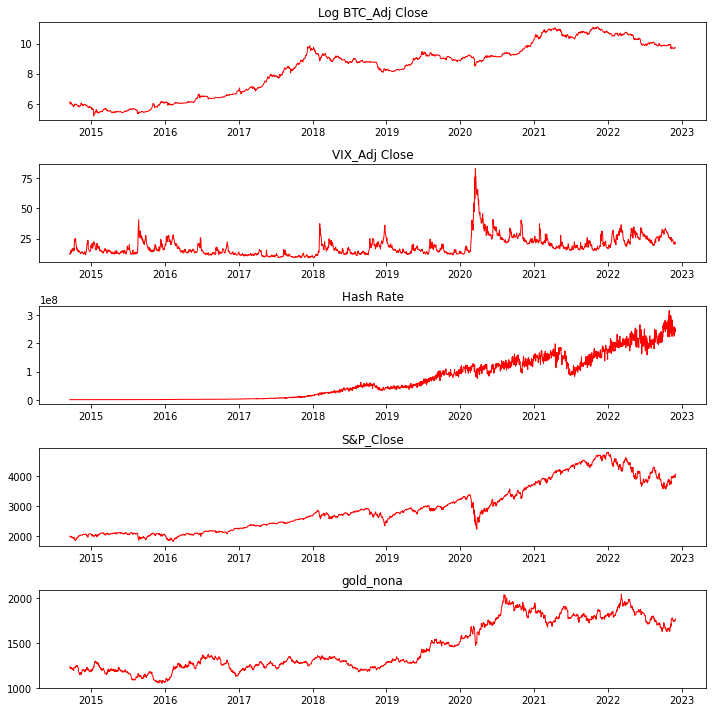

In [92]:
# 画出八个时间序列的图像
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
plt.tight_layout();

In [93]:
# step2：Granger’s Causality Test ， 检验不同序列之间存在互相影响
maxlag=12
test='ssr_chi2test'
variables=df.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Log BTC_Adj Close_x,VIX_Adj Close_x,Hash Rate_x,S&P_Close_x,gold_nona_x
Log BTC_Adj Close_y,1.0000,0.0492,0.1512,0.2560,0.0597
VIX_Adj Close_y,0.0008,1.0000,0.0003,0.0002,0.0004
Hash Rate_y,0.0000,0.0555,1.0000,0.0000,0.0000
S&P_Close_y,0.0062,0.0000,0.0000,1.0000,0.0153
gold_nona_y,0.0550,0.0003,0.0002,0.0256,1.0000


In [94]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [95]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Log BTC_Adj Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0111
 No. Lags Chosen       = 0
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.7492. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "VIX_Adj Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7895
 No. Lags Chosen       = 9
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Hash Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has un

In [97]:
# step4: 协整检验，检验多变量平稳性 ?????????????都false咋办
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Log BTC_Adj Close ::  96.63     > 60.0627   =>   True
VIX_Adj Close ::  29.01     > 40.1749   =>   False
Hash Rate ::  17.37     > 24.2761   =>   False
S&P_Close ::  6.25      > 12.3212   =>   False
gold_nona ::  0.85      > 4.1296    =>   False


In [117]:
# step5：划分训练集和测试集
nobs = 4  # 最后四个时间点作为测试集
df_train, df_test = df[0:-nobs], df[-nobs:]
df_train.head()

,Log BTC_Adj Close,VIX_Adj Close,Hash Rate,S&P_Close,gold_nona
Date,,,,,
2014-09-17,6.125414,12.65,274326.1542,2001.57,1236.5
2014-09-18,6.050771,12.03,240220.7404,2011.36,1223.0
2014-09-19,5.978369,12.11,240220.7404,2010.40,1222.5
2014-09-22,5.996830,13.69,232806.5200,1994.29,1214.0
2014-09-23,6.077163,14.93,241703.5845,1982.77,1225.0


In [103]:
# step6：使用VAR之间，先差分处理使单个变量变得平稳
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Log BTC_Adj Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -25.03
 No. Lags Chosen       = 2
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "VIX_Adj Close" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.0494
 No. Lags Chosen       = 8
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Hash Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Si

In [106]:
# step7：选择模型阶数并训练，根据AIC值，lag=2时达到局部最优
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic, '\n')

Lag Order = 1
AIC :  39.0851335290512 

Lag Order = 2
AIC :  38.93849446559865 

Lag Order = 3
AIC :  38.90883036199057 

Lag Order = 4
AIC :  38.854780399379685 

Lag Order = 5
AIC :  38.85091913671336 

Lag Order = 6
AIC :  38.854918225514105 

Lag Order = 7
AIC :  38.839611663036244 

Lag Order = 8
AIC :  38.83360869934205 

Lag Order = 9
AIC :  38.82809503668946 



/Users/miyuxin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [107]:
# 选择lag=2拟合模型
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Dec, 2022
Time:                     14:38:34
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    39.0888
Nobs:                     2060.00    HQIC:                   38.9936
Log likelihood:          -54666.7    FPE:                8.14279e+16
AIC:                      38.9385    Det(Omega_mle):     7.92883e+16
--------------------------------------------------------------------
Results for equation Log BTC_Adj Close
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.001818         0.001019            1.783           0.075
L1.Log BTC_Adj Close        -0.002004         0.022815           -0.088           0.930
L1.VIX_Adj Close    

In [109]:
# step8：durbin watson test，检验残差项中是否还存在相关性，这一步的目的是确保模型已经解释了数据中所有的方差和模式
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  # 检验值越接近2，说明模型越好

Log BTC_Adj Close : 2.0
VIX_Adj Close : 2.01
Hash Rate : 2.12
S&P_Close : 2.01
gold_nona : 2.0


In [112]:
# step9：下一步进行预测
lag_order = model_fitted.k_ar
forecast_input = df_differenced.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Log BTC_Adj Close_2d,VIX_Adj Close_2d,Hash Rate_2d,S&P_Close_2d,gold_nona_2d
Date,,,,,
2022-11-25,0.003141,0.241674,-1.506857e+07,1.888606,1.790691
2022-11-28,0.004224,-0.156302,3.854672e+05,6.063018,1.601774
2022-11-29,0.000166,0.153289,5.345320e+06,-2.063304,-1.477551
2022-11-30,0.002598,-0.036086,-3.295031e+06,2.115432,0.944621


In [125]:
# step10：将差分后的值还原为原数据
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # 写一个长度为6的数列，用纸笔写出差分的计算过程，可以帮助理解下面这两行还原过程
        df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [126]:
df_results = invert_transformation(df_train, df_forecast)  
df_results.loc[:, ['Log BTC_Adj Close_forecast', 'VIX_Adj Close_forecast', 'Hash Rate_forecast', 'S&P_Close_forecast',
                   'gold_nona_forecast']]

,Log BTC_Adj Close_forecast,VIX_Adj Close_forecast,Hash Rate_forecast,S&P_Close_forecast,gold_nona_forecast
Date,,,,,
2022-11-25,9.746612,19.651673,2.714752e+08,4052.828606,1760.880691
2022-11-28,9.779645,18.797045,2.843444e+08,4084.460230,1773.773157
2022-11-29,9.812843,18.095706,3.025589e+08,4114.028550,1785.188071
2022-11-30,9.848640,17.358280,3.174784e+08,4145.712301,1797.547606


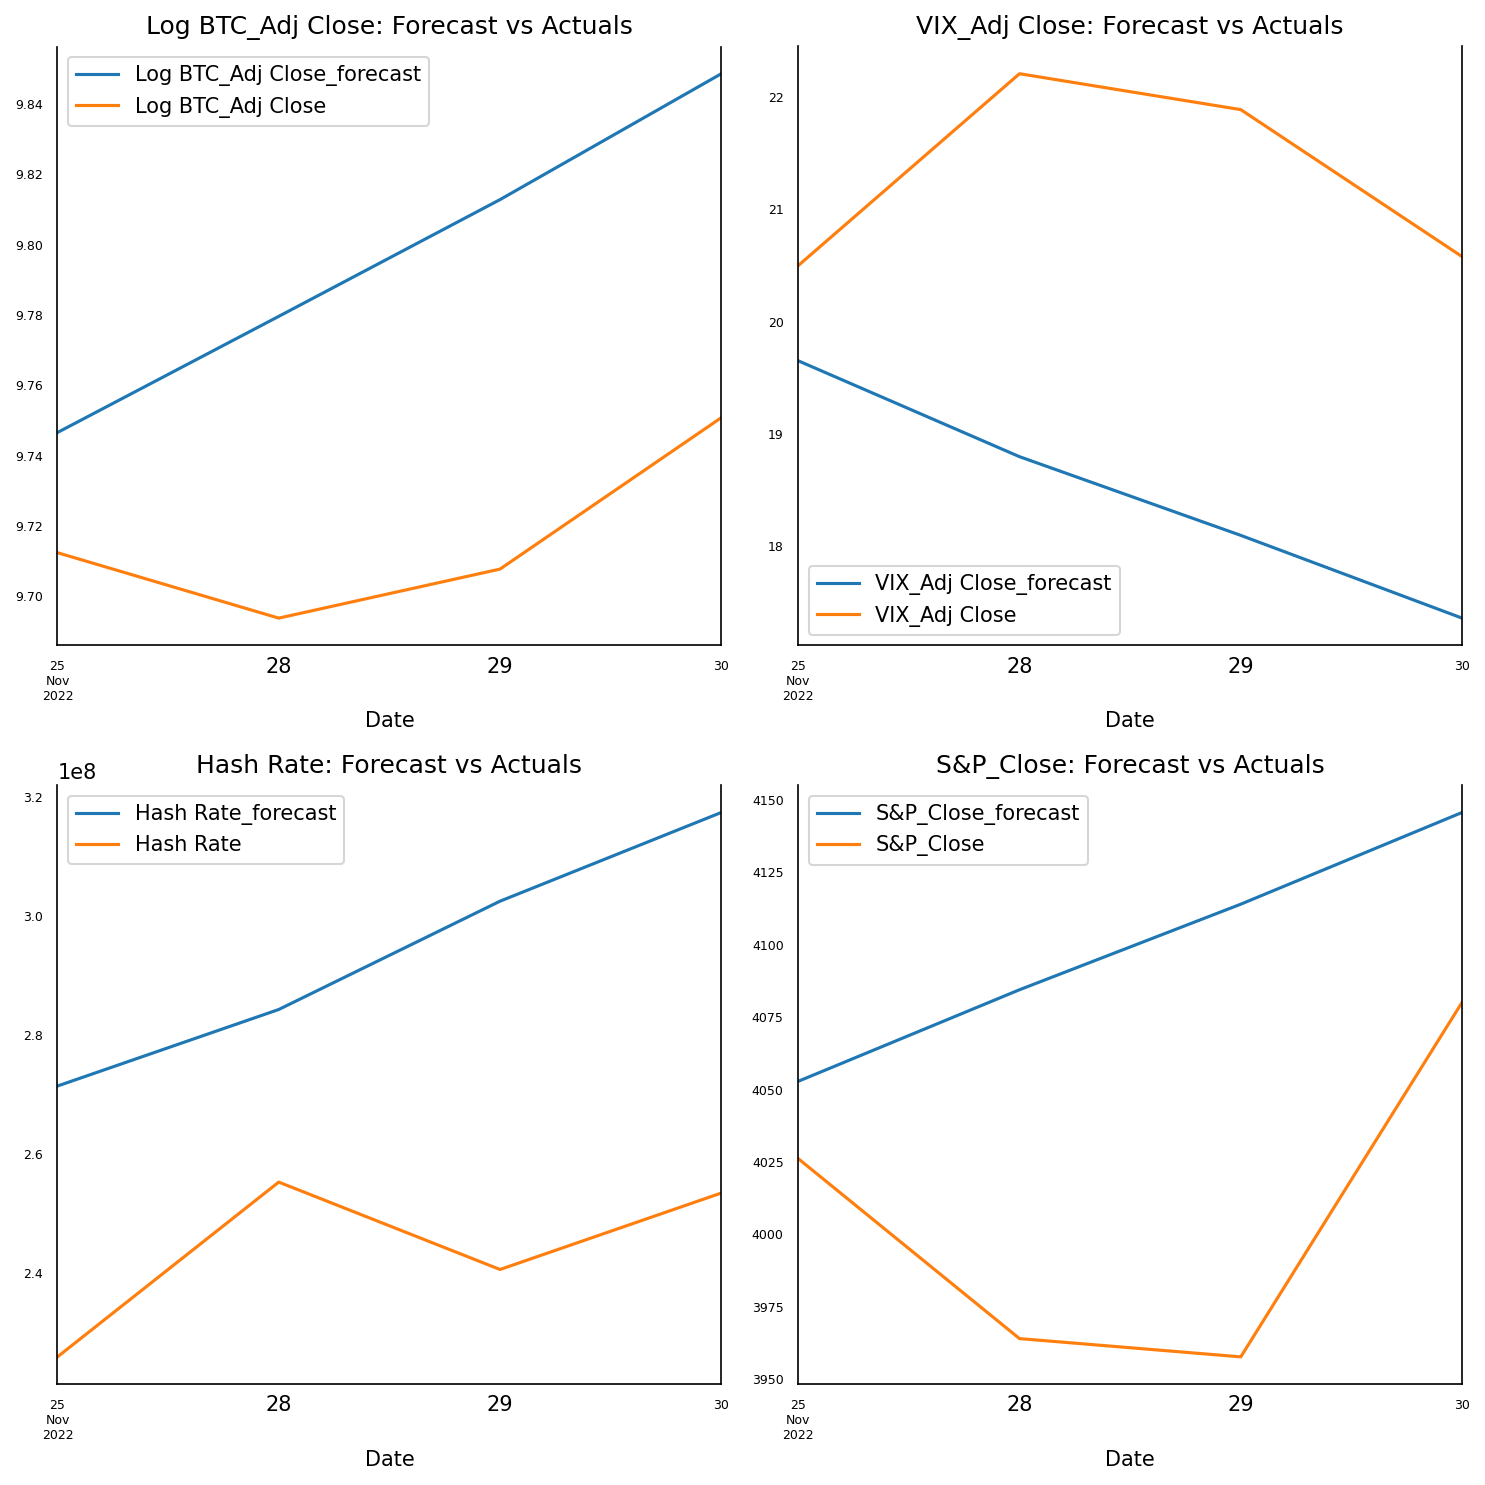

In [127]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();